### Regression plots
1. Calculate NDJ Nino3.4 index using HadISST from 1948-2017
2. Calculate monthly temperature anomalies using NCEP/NCAR Reanalysis from 1948-12 to 2017-11 and smooth using 3-month running mean 
3. Calulate instantaneous regression between NDJ Nino3.4 index amd NDJ temperature anomalies 
4. Calculate regression between NDJ nino3.4 index and temperature anomalies 6 month either side
5. Repeat for precipitaion using NCEP/NCAR
6. Repeat for TXx and Rx1day

### Imports

In [1]:
import xarray as xr
import numpy as np
import pandas
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import scipy.stats
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

### Data

In [2]:
#HadISST 1948-2017
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst
#TXx from HadEX3 
TXx_ds = xr.open_dataset('/g/data/w40/rl5183/HadEX3_TXx_1901-2018_ADW_61-90_1.25x1.875deg.nc', chunks={})

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'Ann' has multiple fill values {-99.9, -99.9}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'Jan' has multiple fill values {-99.9, -99.9}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'Feb' has multiple fill values {-99.9, -99.9}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'Mar' has multiple fill values {-99.9, -99.9}, decoding all values to NaN.
  new_vars[k] = deco

In [3]:
# Combine months from HadEX dataset and rewrite with datetime so all one one axis 
TXx_ds = TXx_ds.rename(time='year')
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# Join the monthly variables along a new 'month' axis
TXx_4d = xr.concat([TXx_ds[m] for m in months], dim='month')
TXx_4d.coords['month'] = months
# Use 'stack' to combine the year and month coordinates
TXx_3d = TXx_4d.stack(time=['year','month'])
# Make a new time axis with Pandas
time = pandas.date_range('19010101', periods = TXx_3d.sizes['time'], freq='MS')
# Override the time axis with the new dates
TXx_3d.coords['time'] = time

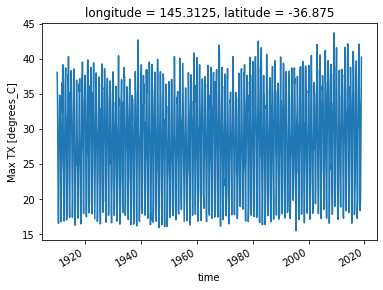

In [4]:
TXx_3d.sel(longitude=144.9, latitude=-37.38, method='nearest').plot()

### Detrend

In [5]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

In [6]:
# Function to detrend when grouped by month 
def detrend_by_month(data):
    detrended_data = np.apply_along_axis(func.detrend_2step, data.get_axis_num('time'), data)
    return xr.DataArray(detrended_data, data.coords)

In [7]:
# Detrend TXx by month 
TXx_detrend = TXx_3d.groupby('time.month').map(detrend_by_month)
TXx_detrended = TXx_detrend.sel(time=slice('1948-11', '2016-10'))

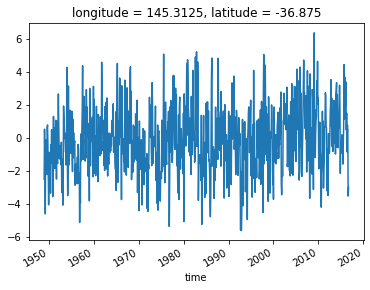

In [9]:
TXx_detrended.sel(longitude=144.9, latitude=-37.38, method='nearest').plot()

### Calculate Nino3.4 index 

In [10]:
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1948-11', '2016-10'))/sst_std

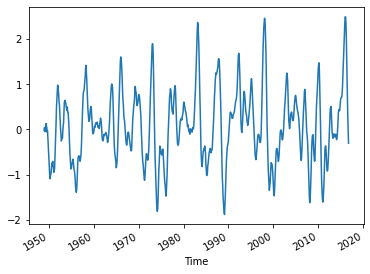

In [11]:
nino34_index.plot()

### Calculate instantaneous regression

In [12]:
def regress_nino(data, nino):
    """
    Returns the linear regression at each gridpoint of 'data' against 'nino'
    """
    
    # Get the nino values at the dates matching 'data'
    #nino = nino.sel(time=data.time)
    
    # Function to apply on each gridpoint
    def regress_gridpoint(data):
        return scipy.stats.linregress(nino, data)[0]
    
    # Apply the function on each gridpoint
    regression = np.apply_along_axis(regress_gridpoint, data.get_axis_num('time'), data)
    
    # This is just to get the correct coordinates for the output
    sample = data.mean('time')
    
    # Convert the numpy array back into xarray
    return xr.DataArray(regression, sample.coords)

def regress_nino_by_month(data, nino):
    """
    Runs 'regress_nino' on each month separately.
    If quarterly or seasonal averages are inputted, will run on each quarter or season seperately. 
    """
    
    return data.groupby('time.month').map(regress_nino, nino=nino)

In [13]:
# The max over every quarter, starting at nov 
quarterly_max_temp = TXx_detrended.resample(time='QS-NOV').max('time')
quarterly_nino = nino34_index.resample(time='QS-NOV').mean('time')

In [14]:
# Select out NDJ nino34 index
nino_ndj = quarterly_nino.isel(time=slice(0,None,4))

In [15]:
# The regression for each season between temp_anom and nino
quarterly_regression_temp = regress_nino_by_month(quarterly_max_temp, nino_ndj)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0, 0.5, 'Degrees [C]')

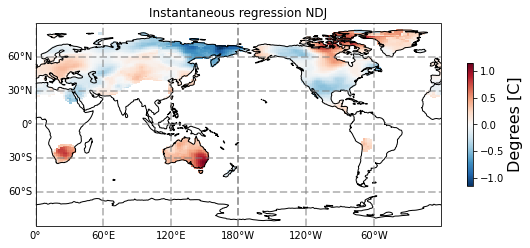

In [16]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
C = quarterly_regression_temp.sel(month=11).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous regression NDJ')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

cbar = plt.colorbar(C, ax=ax, shrink=0.5, pad=0.05)
cbar.ax.set_ylabel('Degrees [C]', fontsize=16)

### Calculate maximum regression

In [17]:
# SHIFT TIMSERIES SO J,J,A,S,O,N IN YEAR 0 AND J,F,M,A,M IN YEAR 1
TXx_lag = TXx_detrend.sel(time=slice('1948-06', '2016-05'))

In [18]:
# Calculate NDJ nino34 regression onto each month using regress nino function
monthly_regression_temp = regress_nino_by_month(TXx_lag, nino_ndj)

In [19]:
# Find maximum across all months and month in which maximum occurs 
temp_stack = np.dstack((monthly_regression_temp.sel(month=6), 
                       monthly_regression_temp.sel(month=7), 
                       monthly_regression_temp.sel(month=8),
                       monthly_regression_temp.sel(month=9),
                       monthly_regression_temp.sel(month=10),
                       monthly_regression_temp.sel(month=11),
                       monthly_regression_temp.sel(month=12),
                       monthly_regression_temp.sel(month=1),
                       monthly_regression_temp.sel(month=2),
                       monthly_regression_temp.sel(month=3),
                       monthly_regression_temp.sel(month=4),
                       monthly_regression_temp.sel(month=5)))
# Find maximum across all months
max_regression_temp = temp_stack.max(2)
min_regression_temp = temp_stack.min(2)
# Find month of max
max_month_temp = temp_stack.argmax(2) +1
min_month_temp = temp_stack.argmin(2) +1

In [20]:
# Find absolute max of max_regression and min_regression, recording month 
abs_max_temp = np.empty(shape=np.shape(max_regression_temp))
months_temp = np.empty(shape=np.shape(max_month_temp))

for i in np.arange(0,np.shape(max_regression_temp)[0]):
    for j in np.arange(0,np.shape(max_regression_temp)[1]):
        if abs(max_regression_temp[i,j]) > abs(min_regression_temp[i,j]):
            abs_max_temp[i,j] = max_regression_temp[i,j]
            months_temp[i,j] = max_month_temp[i,j]
        elif abs(max_regression_temp[i,j]) < abs(min_regression_temp[i,j]):
            abs_max_temp[i,j] = min_regression_temp[i,j]
            months_temp[i,j] = min_month_temp[i,j]
        else:
            abs_max_temp[i,j] = np.NaN
            months_temp[i,j] = np.NaN

In [21]:
# Convert to xarray
sample = TXx_detrended.mean('time')
maximum_regression_temp = xr.DataArray(abs_max_temp, coords=sample.coords, attrs=sample.attrs)
month_of_max_regression_temp = xr.DataArray(months_temp, coords=sample.coords, attrs=sample.attrs)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0, 0.5, 'Degrees [C]')

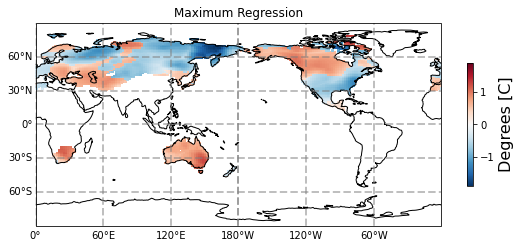

In [22]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
C = maximum_regression_temp.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
ax.set_global()
ax.set_title('Maximum Regression')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

cbar = plt.colorbar(C, ax=ax, shrink=0.5, pad=0.05)
cbar.ax.set_ylabel('Degrees [C]', fontsize=16)

### Lag of maximum regression

In [23]:
import matplotlib as mpl
cmap_lag = mpl.colors.ListedColormap(['forestgreen', 'mediumseagreen', 'mediumaquamarine', 'paleturquoise', 'lightcyan', 'azure', 'lightgrey', 'lavenderblush', 'pink', 'palevioletred', 'mediumvioletred', 'crimson'])
bounds = np.arange(0,13)
norm = mpl.colors.BoundaryNorm(bounds+0.5, cmap_lag.N)

[Text(1, 1.0, 'Jun (0)'),
 Text(1, 2.0, 'Jul (0)'),
 Text(1, 3.0, 'Aug (0)'),
 Text(1, 4.0, 'Sep (0)'),
 Text(1, 5.0, 'Oct (0)'),
 Text(1, 6.0, 'Nov (0)'),
 Text(1, 7.0, 'Dec (0)'),
 Text(1, 8.0, 'Jan (+1)'),
 Text(1, 9.0, 'Feb (+1)'),
 Text(1, 10.0, 'Mar (+1)'),
 Text(1, 11.0, 'Apr (+1)'),
 Text(1, 12.0, 'May (+1)')]

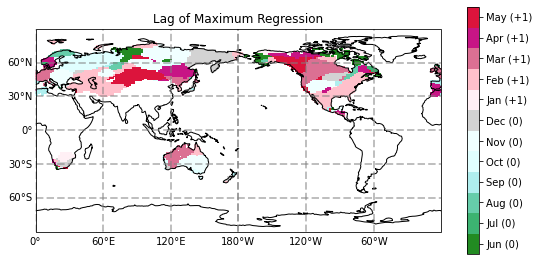

In [24]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
C = month_of_max_regression_temp.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_lag, norm=norm, levels=bounds+0.5)
ax.coastlines()
ax.set_global()
ax.set_title('Lag of Maximum Regression')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

cbar = plt.colorbar(C, ax=ax, ticks=bounds, pad=0.05)
cbar.ax.set_yticklabels(['Jun (0)', 'Jul (0)', 'Aug (0)', 'Sep (0)', 'Oct (0)', 'Nov (0)', 'Dec (0)', 'Jan (+1)', 'Feb (+1)', 'Mar (+1)', 'Apr (+1)', 'May (+1)'])

### Rx1day

In [25]:
Rx1_ds = xr.open_dataset('/g/data/w40/rl5183/HadEX3_Rx1day_1901-2018_ADW_61-90_1.25x1.875deg.nc', chunks={})

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'Ann' has multiple fill values {-99.9, -99.9}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'Jan' has multiple fill values {-99.9, -99.9}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'Feb' has multiple fill values {-99.9, -99.9}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'Mar' has multiple fill values {-99.9, -99.9}, decoding all values to NaN.
  new_vars[k] = deco

In [26]:
# Combine months from HadEX dataset and rewrite with datetime so all one one axis 
Rx1_ds = Rx1_ds.rename(time='year')
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# Join the monthly variables along a new 'month' axis
Rx1_4d = xr.concat([Rx1_ds[m] for m in months], dim='month')
Rx1_4d.coords['month'] = months
# Use 'stack' to combine the year and month coordinates
Rx1_3d = Rx1_4d.stack(time=['year','month'])
# Make a new time axis with Pandas
time = pandas.date_range('19010101', periods = Rx1_3d.sizes['time'], freq='MS')
# Override the time axis with the new dates
Rx1_3d.coords['time'] = time
# Select time
Rx1 = Rx1_3d.sel(time=slice('1948-11', '2016-10'))

In [27]:
# The max over every quarter, starting at nov 
quarterly_max_precip = Rx1.resample(time='QS-NOV').max('time')

In [28]:
# The regression for each season between Rx1 and nino
quarterly_regression_precip = regress_nino_by_month(quarterly_max_precip, nino_ndj)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0, 0.5, 'mm per month')

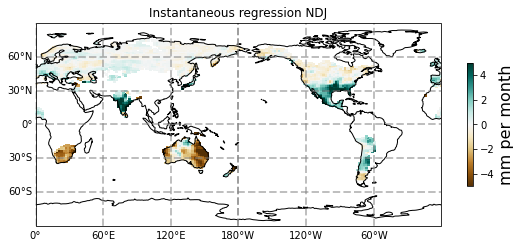

In [29]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
C = quarterly_regression_precip.sel(month=11).plot(ax=ax, vmin=-5, vmax=5, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='BrBG')
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous regression NDJ')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

cbar = plt.colorbar(C, ax=ax, shrink=0.5, pad=0.05)
cbar.ax.set_ylabel('mm per month', fontsize=16)

### Maximum regression

In [30]:
Rx1_lag = Rx1_3d.sel(time=slice('1948-06', '2016-05'))

In [31]:
# Calculate NDJ nino34 regression onto each month using regress nino function
monthly_regression_precip = regress_nino_by_month(Rx1_lag, nino_ndj)

In [32]:
# Find maximum across all months and month in which maximum occurs 
precip_stack = np.dstack((monthly_regression_precip.sel(month=6), 
                       monthly_regression_precip.sel(month=7), 
                       monthly_regression_precip.sel(month=8),
                       monthly_regression_precip.sel(month=9),
                       monthly_regression_precip.sel(month=10),
                       monthly_regression_precip.sel(month=11),
                       monthly_regression_precip.sel(month=12),
                       monthly_regression_precip.sel(month=1),
                       monthly_regression_precip.sel(month=2),
                       monthly_regression_precip.sel(month=3),
                       monthly_regression_precip.sel(month=4),
                       monthly_regression_precip.sel(month=5)))
# Find maximum across all months
max_regression_precip = precip_stack.max(2)
min_regression_precip = precip_stack.min(2)
# Find month of max
max_month_precip = precip_stack.argmax(2) +1
min_month_precip = precip_stack.argmin(2) +1

In [33]:
# Find absolute max of max_regression and min_regression, recording month 
abs_max_precip = np.empty(shape=np.shape(max_regression_precip))
months_precip = np.empty(shape=np.shape(max_month_precip))

for i in np.arange(0,np.shape(max_regression_precip)[0]):
    for j in np.arange(0,np.shape(max_regression_precip)[1]):
        if abs(max_regression_precip[i,j]) > abs(min_regression_precip[i,j]):
            abs_max_precip[i,j] = max_regression_precip[i,j]
            months_precip[i,j] = max_month_precip[i,j]
        elif abs(max_regression_precip[i,j]) < abs(min_regression_precip[i,j]):
            abs_max_precip[i,j] = min_regression_precip[i,j]
            months_precip[i,j] = min_month_precip[i,j]
        else:
            abs_max_precip[i,j] = np.NaN
            months_precip[i,j] = np.NaN

In [34]:
# Convert to xarray
sample = Rx1.mean('time')
maximum_regression_precip = xr.DataArray(abs_max_precip, coords=sample.coords, attrs=sample.attrs)
month_of_max_regression_precip = xr.DataArray(months_precip, coords=sample.coords, attrs=sample.attrs)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0, 0.5, 'mm per month')

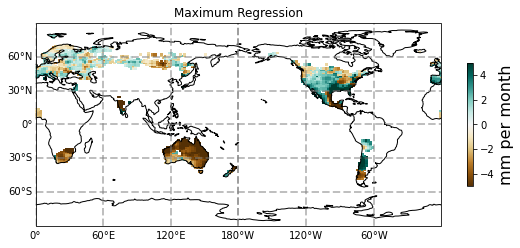

In [35]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
C = maximum_regression_precip.plot(ax=ax, vmin=-5, vmax=5, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='BrBG')
ax.coastlines()
ax.set_global()
ax.set_title('Maximum Regression')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

cbar = plt.colorbar(C, ax=ax, shrink=0.5, pad=0.05)
cbar.ax.set_ylabel('mm per month', fontsize=16)

### Lag of maximum regression

[Text(1, 1.0, 'Jun (0)'),
 Text(1, 2.0, 'Jul (0)'),
 Text(1, 3.0, 'Aug (0)'),
 Text(1, 4.0, 'Sep (0)'),
 Text(1, 5.0, 'Oct (0)'),
 Text(1, 6.0, 'Nov (0)'),
 Text(1, 7.0, 'Dec (0)'),
 Text(1, 8.0, 'Jan (+1)'),
 Text(1, 9.0, 'Feb (+1)'),
 Text(1, 10.0, 'Mar (+1)'),
 Text(1, 11.0, 'Apr (+1)'),
 Text(1, 12.0, 'May (+1)')]

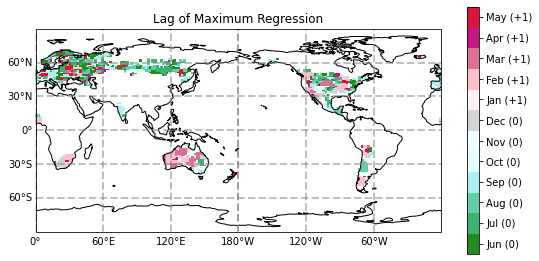

In [36]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
C = month_of_max_regression_precip.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_lag, norm=norm, levels=bounds+0.5)
ax.coastlines()
ax.set_global()
ax.set_title('Lag of Maximum Regression')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

cbar = plt.colorbar(C, ax=ax, ticks=bounds, pad=0.05)
cbar.ax.set_yticklabels(['Jun (0)', 'Jul (0)', 'Aug (0)', 'Sep (0)', 'Oct (0)', 'Nov (0)', 'Dec (0)', 'Jan (+1)', 'Feb (+1)', 'Mar (+1)', 'Apr (+1)', 'May (+1)'])

### Combine plots in one figure and save

<ipython-input-47-04ca15e6a9cc>:55: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('maximum_regression_TXx.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
<ipython-input-47-04ca15e6a9cc>:55: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig('maximum_regression_TXx.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
<ipython-input-47-04ca15e6a9cc>:55: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Mat

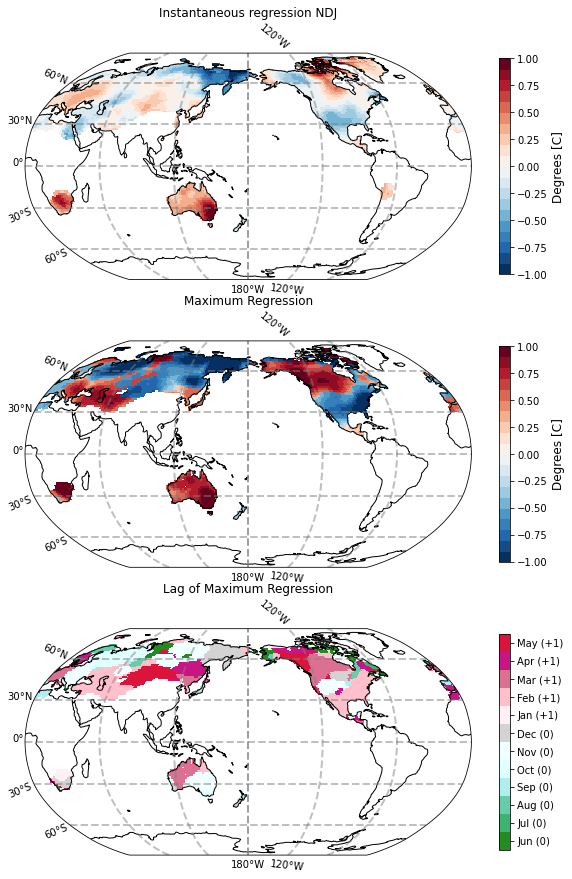

In [47]:
fig = plt.figure(figsize=(10,15))

vmin=-1
vmax=1

ax = fig.add_subplot(311, projection=ccrs.Robinson(180))
C = quarterly_regression_temp.sel(month=11).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous regression NDJ')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('Degrees [C]', fontsize=12)

ax = fig.add_subplot(312, projection=ccrs.Robinson(180))
C = maximum_regression_temp.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Maximum Regression')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('Degrees [C]', fontsize=12)

ax = fig.add_subplot(313, projection=ccrs.Robinson(180))
C = month_of_max_regression_temp.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_lag, norm=norm, levels=bounds+0.5)
ax.coastlines()
ax.set_global()
ax.set_title('Lag of Maximum Regression')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# Colorbar 
cbar = plt.colorbar(C, ax=ax, ticks=bounds, shrink=0.9, pad=0.05)
cbar.ax.set_yticklabels(['Jun (0)', 'Jul (0)', 'Aug (0)', 'Sep (0)', 'Oct (0)', 'Nov (0)', 'Dec (0)', 'Jan (+1)', 'Feb (+1)', 'Mar (+1)', 'Apr (+1)', 'May (+1)'])

# Save figure
# plt.savefig('maximum_regression_TXx.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

<ipython-input-48-a6e0d947a8f5>:55: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('maximum_regression_Rx1day.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
<ipython-input-48-a6e0d947a8f5>:55: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig('maximum_regression_Rx1day.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
<ipython-input-48-a6e0d947a8f5>:55: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated 

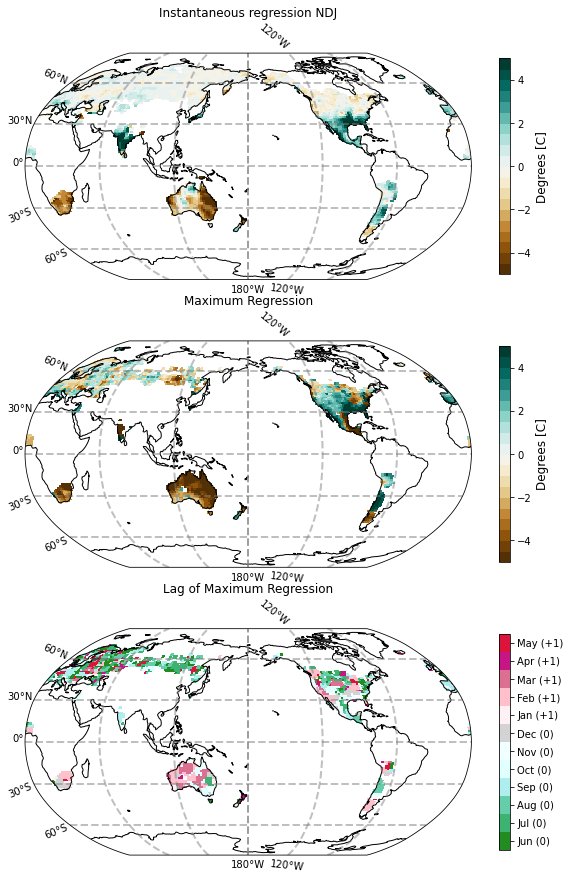

In [48]:
fig = plt.figure(figsize=(10,15))

vmin=-5
vmax=5

ax = fig.add_subplot(311, projection=ccrs.Robinson(180))
C = quarterly_regression_precip.sel(month=11).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous regression NDJ')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('Degrees [C]', fontsize=12)

ax = fig.add_subplot(312, projection=ccrs.Robinson(180))
C = maximum_regression_precip.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Maximum Regression')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('Degrees [C]', fontsize=12)

ax = fig.add_subplot(313, projection=ccrs.Robinson(180))
C = month_of_max_regression_precip.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_lag, norm=norm, levels=bounds+0.5)
ax.coastlines()
ax.set_global()
ax.set_title('Lag of Maximum Regression')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# Colorbar 
cbar = plt.colorbar(C, ax=ax, ticks=bounds, shrink=0.9, pad=0.05)
cbar.ax.set_yticklabels(['Jun (0)', 'Jul (0)', 'Aug (0)', 'Sep (0)', 'Oct (0)', 'Nov (0)', 'Dec (0)', 'Jan (+1)', 'Feb (+1)', 'Mar (+1)', 'Apr (+1)', 'May (+1)'])

# Save figure
# plt.savefig('maximum_regression_Rx1day.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)